In [8]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

In [9]:
from tensorflow.keras.layers import Flatten,Dense,Input
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [17]:
IMAGES_PATH = "training_images"
ANNOTS_PATH = "train_solution_bounding_boxes.csv"
TEST_FILENAMES = "test_filenames.txt"

In [18]:
annot = open(ANNOTS_PATH).read().strip().split("\n")

data = []
targets = []
filenames = []

In [19]:
annot[1]

'vid_4_1000.jpg,281.2590449,187.0350708,327.7279305,223.225547'

In [20]:
for row in annot[1:]:
    row = row.split(",")
    (filename, startX, startY, endX, endY) = row
    imagePath = os.path.join(IMAGES_PATH, filename)
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [25]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# Save the list of testing filenames to a file
with open(TEST_FILENAMES, "w") as f:
    f.write("\n".join(testFilenames))

In [26]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
flatten = base_model.output
flatten = Flatten()(flatten)

bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

model = Model(inputs=base_model.input, outputs=bboxHead)


In [28]:
opt = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["accuracy"])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2_act (Activ  (None, 28, 28, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 28, 28, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 28, 28, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 14, 14, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 14, 14, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 14, 14, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 14, 14, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 14, 14, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 14, 14, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 14, 14, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 14, 14, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 14, 14, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [29]:
history = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    shuffle=True,
    batch_size=32,
    epochs=10,
    verbose=1
)

Epoch 1/10


16/16 [==============================] - 46s 2s/step - loss: 0.0545 - accuracy: 0.5487 - val_loss: 0.0469 - val_accuracy: 0.4464
Epoch 2/10
16/16 [==============================] - 36s 2s/step - loss: 0.0509 - accuracy: 0.5408 - val_loss: 0.0550 - val_accuracy: 0.4464
Epoch 3/10
16/16 [==============================] - 36s 2s/step - loss: 0.0496 - accuracy: 0.5905 - val_loss: 0.0482 - val_accuracy: 0.4464
Epoch 4/10
16/16 [==============================] - 38s 2s/step - loss: 0.0499 - accuracy: 0.5905 - val_loss: 0.0498 - val_accuracy: 0.4464
Epoch 5/10
16/16 [==============================] - 36s 2s/step - loss: 0.0488 - accuracy: 0.5924 - val_loss: 0.0453 - val_accuracy: 0.4464
Epoch 6/10
16/16 [==============================] - 35s 2s/step - loss: 0.0493 - accuracy: 0.5924 - val_loss: 0.0502 - val_accuracy: 0.4464
Epoch 7/10
16/16 [==============================] - 35s 2s/step - loss: 0.0483 - accuracy: 0.5785 - val_loss: 0.0512 - val_accuracy: 0.4464
Epoch 8/10
16/16 [

In [30]:
model.save("detector.h5")

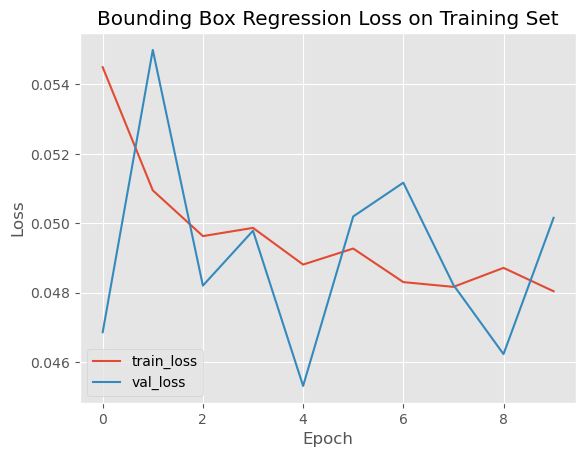

In [32]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left");

In [33]:
#loading object detector
model = load_model("detector.h5")

1/1 [==============================] - 3s 3s/step


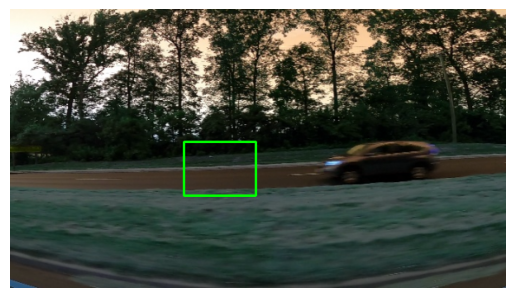

In [38]:
import imutils
imagePath = "\testing_images\vid_5_31700.jpg"

image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds

image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
plt.axis('off')
plt.imshow(image);